In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score


In [6]:
# Load the data
data = pd.read_csv('data_matrix.csv')

# Extract features and labels
X = data.drop(columns=['label'])
y = data['label']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))),
    ('svm', make_pipeline(StandardScaler(), SVC())),
    ('rf', RandomForestClassifier())
]


# Define stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())


# Define hyperparameters for random search
param_distributions = {
    'lr__logisticregression__C': [0.1, 1.0, 10.0],
    'svm__svc__C': [0.1, 1.0, 10.0],
    'svm__svc__gamma': ['scale', 'auto'],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 5, 10],
}

# Perform random search
random_search = RandomizedSearchCV(stacking_clf, param_distributions, n_iter=50, cv=4, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best parameters: {random_search.best_params_}")

# Evaluate the model on the test set
test_score = random_search.score(X_test, y_test)
print(f"Test accuracy: {test_score}")

Best parameters: {'svm__svc__gamma': 'auto', 'svm__svc__C': 10.0, 'rf__n_estimators': 100, 'rf__max_depth': None, 'lr__logisticregression__C': 10.0}
Test accuracy: 0.9303030303030303


Accuracy: 0.9303030303030303
Recall: 0.9144736842105263
Precision: 0.9328859060402684
F1 Score: 0.9235880398671096
Confusion Matrix:
[[168  10]
 [ 13 139]]
ROC-AUC Score: 0.9853636901241869


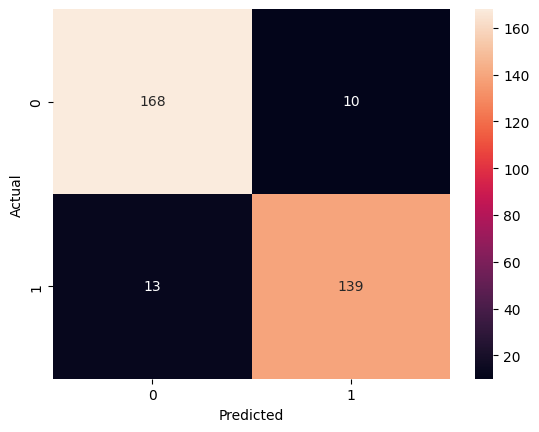

In [12]:
# Make predictions
y_pred = random_search.predict(X_test)
y_prob = random_search.predict_proba(X_test)[:,1]  # probabilities for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curve
# plot_roc_curve(random_search, X_test, y_test)



# plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In the case of the models that you're using (Logistic Regression, Support Vector Machine, Random Forest), feature importances can be interpreted differently.

For Random Forest model, it has a straightforward method of looking at feature importances by using the feature_importances_ attribute.

Here is a code snippet for it:

In [20]:
rf_model = random_search.best_estimator_.named_estimators_['rf']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Feature names
feature_names = X.columns

# Print the feature ranking with feature names
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))



Feature ranking:
1. feature NOUN (0.131624)
2. feature FULLSTOP (0.117883)
3. feature text_perplexity (0.116848)
4. feature VERB (0.097969)
5. feature avg_sentence_perplexity (0.082632)
6. feature avg_sentence_cosine_similarity (0.078127)
7. feature COMMA (0.066462)
8. feature NUM (0.046186)
9. feature ADJ (0.043838)
10. feature uppercase_freq (0.037090)
11. feature prompt_text_cosine_similarity (0.033880)
12. feature ADV (0.023303)
13. feature FUNCTION-THE (0.020940)
14. feature flesch_kincaid_grade_level (0.017816)
15. feature avg_sentence_length (0.016902)
16. feature avg_word_length (0.015481)
17. feature flesch_reading_ease (0.013571)
18. feature FUNCTION-IN (0.013349)
19. feature FUNCTION-A (0.011236)
20. feature FUNCTION-OF (0.007966)
21. feature SPECIAL- (0.006898)
22. feature CONJ (0.000000)


For Logistic Regression and SVM models, it's a bit trickier because they're not tree-based models. One common way is to look at the coefficients of the model, where each coefficient can be interpreted as the change in log odds of the outcome for a one-unit change in the predictor.

In [28]:
lr_model = random_search.best_estimator_.named_estimators_['lr'].named_steps['logisticregression']
lr_coefficients = lr_model.coef_

# Get the feature names from the data
feature_names = X.columns

# Print the feature names alongside the coefficients
print("Logistic Regression Coefficients:")
for i in range(len(lr_coefficients[0])):
    print(f"{feature_names[i]}: {lr_coefficients[0][i]}")


Logistic Regression Coefficients:
ADJ: 0.4464058504391675
ADV: -1.690451119728589
CONJ: 0.0
NOUN: 1.4156518779560798
NUM: -1.8978275653247945
VERB: -1.0844552312405578
COMMA: 0.2031973457049017
FULLSTOP: -1.3424309648716994
SPECIAL-: -0.3206711213218608
FUNCTION-A: -0.037169732451117064
FUNCTION-IN: -0.3395650671803715
FUNCTION-OF: -0.49672690286354027
FUNCTION-THE: -0.48036434357201124
uppercase_freq: -0.7097177778089054
flesch_reading_ease: -0.4133556064344938
flesch_kincaid_grade_level: -0.32162892099786294
avg_word_length: -1.2965794178173329
avg_sentence_length: 0.6541850173844582
text_perplexity: -1.7079340704300512
avg_sentence_perplexity: -0.435082645263894
prompt_text_cosine_similarity: -1.462593592249678
avg_sentence_cosine_similarity: 8.737994349781957


In order to compute the p-values for the coefficients in Logistic Regression, we need to use the statsmodels package rather than scikit-learn. The scikit-learn library does not provide the functionality to get p-values associated with features. The steps are similar but there are some differences in how the models are defined and fit.

Note: SVM with RBF kernel or Polynomial kernel doesn't provide direct interpretability in terms of original feature importance because they transform features into a high-dimensional space.

The concept of feature importance doesn't have an equivalent in Logistic Regression and Support Vector Machines (SVM) in the same way as it does in tree-based models. For these models, instead of feature importance, we can look into the coefficients of the features to understand the relationship.

For Logistic Regression, the coefficients of the features can tell you about their impact on the predicted outcome. A positive coefficient for a feature indicates that as the feature value increases, the predicted outcome (log-odds) also increases. Conversely, a negative coefficient suggests that as the feature value increases, the predicted outcome decreases. However, keep in mind that this doesn't directly indicate the "importance" of a feature in the same way as a tree model does.

In SVM, the situation is a bit different. When using linear SVM, you can inspect the coefficients of the hyperplane to get an idea about which features contribute more to the decision boundary. However, the interpretation is not straightforward and depends on the scaling of your features. Also, in the case of SVM with non-linear kernels, it's hard to directly interpret feature importance.

Correlation between features (also known as multicollinearity) is worth investigating for linear models like Logistic Regression. If two features are highly correlated, they carry similar information, and this can make the model heavily rely on these features, leading to overfitting and instability (i.e., a slight change in the data may cause large changes in the coefficients).

In your case, as you're using a Stacking Classifier that combines Logistic Regression, SVM, and RandomForest, checking the correlation between features can be useful. For the tree-based model (RandomForest), multicollinearity isn't an issue, but for Logistic Regression and possibly for linear SVM, it could be.

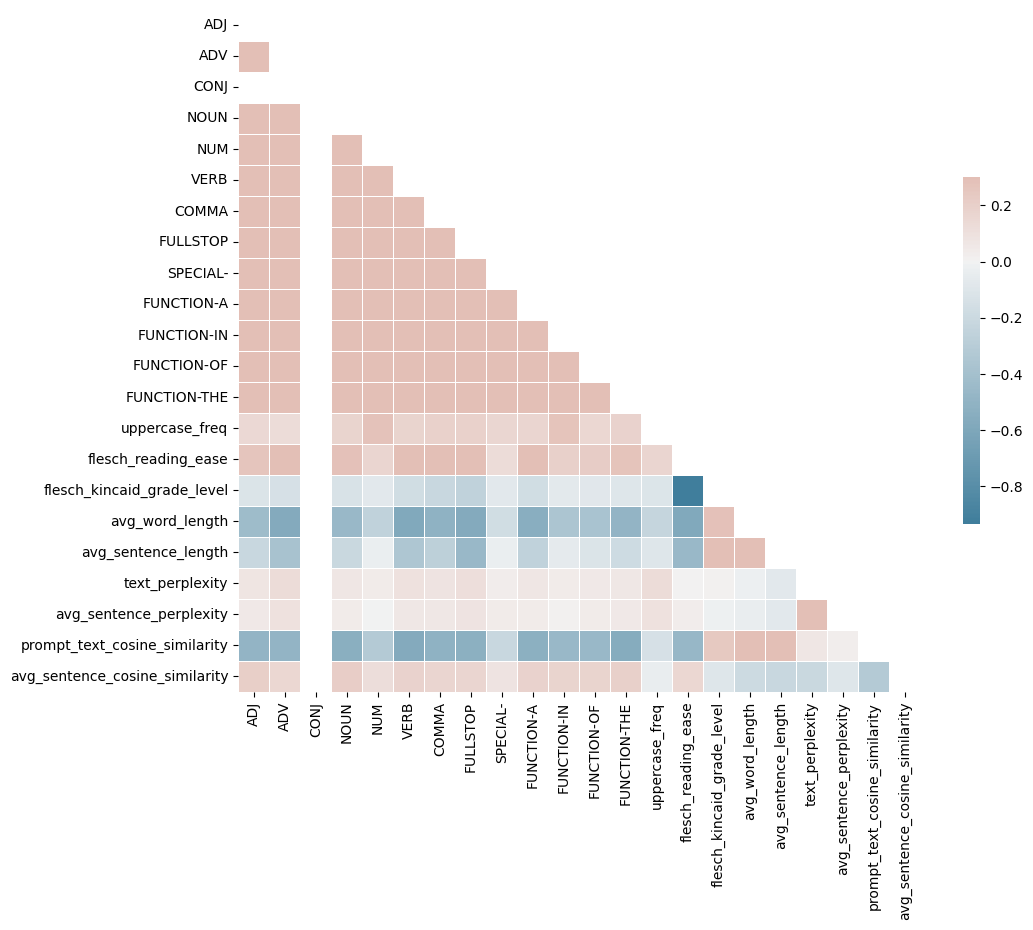

In [25]:
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


This will provide a color-coded heatmap of correlation values. Keep in mind that strong correlation is usually considered when the absolute correlation coefficient is above 0.7 or 0.8.

Remember, if you find highly correlated features, it doesn't necessarily mean you should remove one of them. Correlated features can sometimes still bring some new information. The decision to remove a feature should not be based only on correlation but on a deeper understanding of the problem and the data, possibly using domain knowledge. In addition, feature selection methods can also be applied to choose the most relevant features for your models.

Besides these model-specific methods, Permutation Importance and SHapley Additive exPlanations (SHAP) values are also model-agnostic ways to understand feature importance.

Permutation Importance is calculated after a model has been fitted. Basically, we randomly shuffle each feature and compute how much the performance drops. The features which degrade the performance most when they're shuffled are the most important ones:

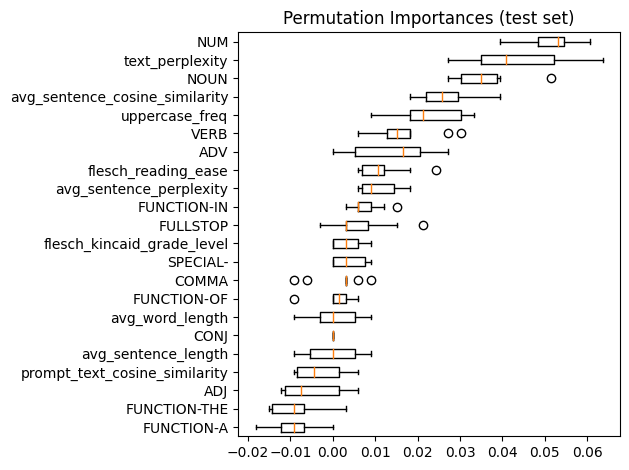

In [18]:
from sklearn.inspection import permutation_importance

result = permutation_importance(random_search, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


Each box in the boxplot represents one feature. The central line in the box indicates the median of the distribution, the box's length (interquartile range) represents the middle 50% of the distribution (from the 25th to the 75th percentile), and the whiskers represent the range of the distribution (typically 1.5 times the interquartile range from the box).

The higher the box on the y-axis, the higher the importance of that feature. Importance here is measured by the decrease in model performance (accuracy, in this case) when the values of that feature are permuted (i.e., randomly shuffled), thereby breaking the relationship between the feature and the target variable. If shuffling a feature's values leads to a large decrease in model performance, then that feature is considered important because the model relies heavily on it to make predictions.

Permutation feature importance is a great way to understand the global importance of features, but do keep in mind that it can be biased when features are correlated. In such cases, the importance is shared among them, and we may undervalue features that are actually important. This is why it's essential to also consider other ways to measure feature importance, like examining the feature coefficients in linear models, using tree-based feature importance in tree-based models, and using SHAP values, among other methods.

It's also worth noting that permutation feature importance depends on the model. Different models could assign different importances to the features.

As for interpretation: The features towards the top of the graph (with higher median values) are those that, when their values are shuffled, tend to decrease the model's performance the most. These are typically your most important features according to the fitted model.

Certainly! I'll show you how to compute and plot SHAP values for a Random Forest model, which is one of the base estimators you used in your stacking classifier.

We'll assume that your RandomizedSearchCV object is named random_search and that 'rf' is the key corresponding to the random forest model in the base estimators of your stacking classifier.

To compute SHAP values, we need to install the shap library. If you haven't installed it, you can do so by running pip install shap in your command line or adding !pip install shap in a Jupyter notebook cell.

Please note that due to an issue with SHAP and certain versions of Numpy, if you see an error regarding np.bool, you might need to downgrade Numpy to a version less than 1.20 (e.g., 1.19.5).